## Lego challenge

Zadaniem na dzisiejsze laboratoria jest rozwiazanie problemu klasyfikacji koloru klocka na podstawie wartosci koloru z jego zdjęcia. Do instrukcji dołączony jest zbiór danych. 
Warto zapoznać się z zawartością zbioru danych i samodzielnie sprawdzić zawartośc plików. 

Zadaniem jest zaproponowanie rozwiązania wykorzystujące techniki uczenia maszynowego w taki sposób, aby osiągnąć jak najwyższą skuteczność klasyfikacji modelu. Oprócz miary 'Accuracy' warto spojrzeć na inne metryki określające poprawność klasyfikacji, jak 'Precision' czy 'Recall' aby dostosować kolejne kroki w poprawie proponowanego rozwiązania. 
Wybór technik i metod jest dowolny. Prosze pamiętać aby na wstępnie `odpowiednio` podzielić zbiór danych na podzbiory Trenujący i Testujący, inaczej określenie poprawności działania zaproponowanej techniki będzie niemożliwe. 

Poniżej przedstawiono sposób wczytania danych do programu oraz wyświetlono dostępne dane w przestrzeni trójwymiarowej (kolor punktu oznacza kolor klocka według producenta).

Powodzenia ! 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px


#from google.colab import drive
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

%matplotlib inline
sns.set_theme(style="darkgrid")

In [2]:
# pobierz zbiory danych 
df_data = pd.read_csv('archive/legocolor-basic.csv', delimiter=";")
df_color = pd.read_csv('archive/colors.csv', delimiter=",")

In [3]:
print(df_data['Color'].unique())

['Orange' 'Medium Azure' 'Dark Azure' 'Aqua' 'Yellow'
 'Bright Light Yellow' 'Bright Pink' 'White' 'Yellowish Green' 'Tan' 'Red'
 'Dark Bluish Grey' 'Black' 'Light Bluish Grey']


In [4]:
color_dict = dict(zip(df_color["name"], df_color["rgb"]))

df_datacolor=df_data["Color"]

df_data['Color'] = df_data['Color'].replace(color_dict)
df_data['Color'] = '#' + df_data['Color'].astype(str)
print(df_data['Color'].unique())

['#FE8A18' '#36AEBF' '#078BC9' '#B3D7D1' '#F2CD37' '#FFF03A' '#E4ADC8'
 '#FFFFFF' '#DFEEA5' '#E4CD9E' '#C91A09' '#6C6E68' '#05131D' '#A0A5A9']


In [5]:
my_cmap = df_data['Color'].unique()

#my_cmap = [x[1:] for x in my_cmap]
fig = px.scatter_3d(df_data, x = 'R', y = 'G', z = 'B', color = 'Color', color_discrete_sequence = my_cmap)
fig.update_traces(marker=dict(size = 2.5))
fig.show()

In [6]:
import tensorflow as tf
X = df_data[['R', 'G', 'B']].values
Y = pd.factorize(df_data['Color'])[0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0)
print(len(X_train), len(X_test), len(Y_train), len(Y_test))

2492
1993 499 1993 499


In [7]:
# konwersja do wektora w stylu hot-one
y_train_cat = np.zeros((Y_train.size, Y_train.max() + 1))
y_train_cat[np.arange(Y_train.size), Y_train] = 1
Y_train = y_train_cat

y_test_cat = np.zeros((Y_test.size, Y_test.max() + 1))
y_test_cat[np.arange(Y_test.size), Y_test] = 1
Y_test = y_test_cat
X_train, X_test = X_train / 255.0, X_test / 255.0

In [8]:
print(f"Rozmiar danych wejściowych: (,{X_train.shape})")
print(f"Rozmiar danych wyjściowych: (,{Y_train.shape})")

Rozmiar danych wejściowych: (,(1993, 3))
Rozmiar danych wyjściowych: (,(1993, 14))


In [9]:
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=0.5, random_state=0)

In [10]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, X_valid.shape, Y_valid.shape)

(1993, 3) (249, 3) (1993, 14) (249, 14) (250, 3) (250, 14)


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(14),
    tf.keras.layers.Softmax()
])

In [12]:
optimizer_met = tf.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights = True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 5))

model.compile(optimizer=optimizer_met,
                loss=loss_fn,
                metrics=['accuracy', 'precision', 'recall'])

History = model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid), epochs=100, batch_size=64, callbacks = [callback, lr_schedule])


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3479 - loss: 6.9912 - precision: 0.4880 - recall: 0.2031 - val_accuracy: 0.0680 - val_loss: 6.5923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6441 - loss: 4.7969 - precision: 0.7409 - recall: 0.5143 - val_accuracy: 0.0840 - val_loss: 5.9028 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6928 - loss: 3.9705 - precision: 0.7650 - recall: 0.5909 - val_accuracy: 0.0640 - val_loss: 5.4819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7470 - loss: 3.4049 - precision: 0.8081 - recall: 0.6667 - val_accuracy: 0.0640 - val_loss: 5.2022 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━

SIEĆ SPLOTOWA


In [31]:
df_data = pd.read_csv('archive/legocolor-basic.csv', delimiter=";")
df_color = pd.read_csv('archive/colors.csv', delimiter=",")
color_dict = dict(zip(df_color["name"], df_color["rgb"]))

df_datacolor=df_data["Color"]

df_data['Color'] = df_data['Color'].replace(color_dict)
df_data['Color'] = '#' + df_data['Color'].astype(str)

X_conv = df_data[['R', 'G', 'B']].values
Y_conv = pd.factorize(df_data['Color'])[0]

X_train_conv, X_test_conv, Y_train_conv, Y_test_conv = train_test_split(X_conv, Y_conv, test_size=0.20, random_state=0)
# konwersja do wektora w stylu hot-one
y_train_cat_conv = np.zeros((Y_train_conv.size, Y_train_conv.max() + 1))
y_train_cat_conv[np.arange(Y_train_conv.size), Y_train_conv] = 1
Y_train_conv = y_train_cat_conv

y_test_cat_conv = np.zeros((Y_test_conv.size, Y_test_conv.max() + 1))
y_test_cat_conv[np.arange(Y_test_conv.size), Y_test_conv] = 1
Y_test_conv = y_test_cat_conv
X_train_conv, X_test_conv = X_train_conv / 255.0, X_test_conv / 255.0

X_test_conv, X_valid_conv, Y_test_conv, Y_valid_conv = train_test_split(X_test_conv, Y_test_conv, test_size=0.5, random_state=0)

X_train_conv = X_train_conv.reshape(-1, 1, 3, 1)
X_valid_conv = X_valid_conv.reshape(-1, 1, 3, 1)
Y_train_conv = tf.keras.utils.to_categorical(Y_train_conv, num_classes=14)
Y_valid_conv = tf.keras.utils.to_categorical(Y_valid_conv, num_classes=14)
X_train_conv = X_train_conv.reshape(-1, 1, 3, 1)
X_valid_conv = X_valid_conv.reshape(-1, 1, 3, 1)

In [60]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (1, 1), activation='relu', input_shape=(1, 3, 1), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((1, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (1, 1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((1, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(14*14),
    tf.keras.layers.Reshape((14, 14)),
    tf.keras.layers.Softmax()
])

In [62]:
optimizer_met = tf.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', min_delta=0.001, mode='max', restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.01 * 0.3 ** (epoch // 5))

model.compile(optimizer=optimizer_met,
                loss=loss_fn,
                metrics=['accuracy', 'precision', 'recall'])

History = model.fit(X_train_conv, Y_train_conv, validation_data=(X_valid_conv, Y_valid_conv), epochs=100, batch_size=128, callbacks=[callback, lr_schedule])

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9332 - loss: 0.1597 - precision: 0.9332 - recall: 0.9331 - val_accuracy: 0.9286 - val_loss: 0.5423 - val_precision: 0.9286 - val_recall: 0.9286 - learning_rate: 0.0100
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9491 - loss: 0.1168 - precision: 0.9491 - recall: 0.9491 - val_accuracy: 0.9286 - val_loss: 0.5713 - val_precision: 0.9286 - val_recall: 0.9286 - learning_rate: 0.0100
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9503 - loss: 0.1101 - precision: 0.9503 - recall: 0.9503 - val_accuracy: 0.9283 - val_loss: 0.5866 - val_precision: 0.9283 - val_recall: 0.9283 - learning_rate: 0.0100
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9526 - loss: 0.1069 - precision: 0.9526 - recall: 0.9526 - val_accuracy: 0.9286 - val_loss: 0.6640 - val_precision: 0.9286 - val_recall: 0.9286 - learning_rate: 0.0100
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.95

ANALIZA DANYCH


In [107]:
df_data = pd.read_csv('archive/legocolor-basic.csv', delimiter=";")
df_color = pd.read_csv('archive/colors.csv', delimiter=",")

In [108]:
color_dict = dict(zip(df_color["name"], df_color["rgb"]))

df_datacolor=df_data["Color"]

df_data['Color'] = df_data['Color'].replace(color_dict)
df_data['Color'] = '#' + df_data['Color'].astype(str)

X = df_data.drop(labels=['X_axis', 'Y_axis', 'Camera', 'Photo_number', 'Color'], axis = 1)
Y = df_data['Color']

Trwa proces przygotowywania danych do wizualicji


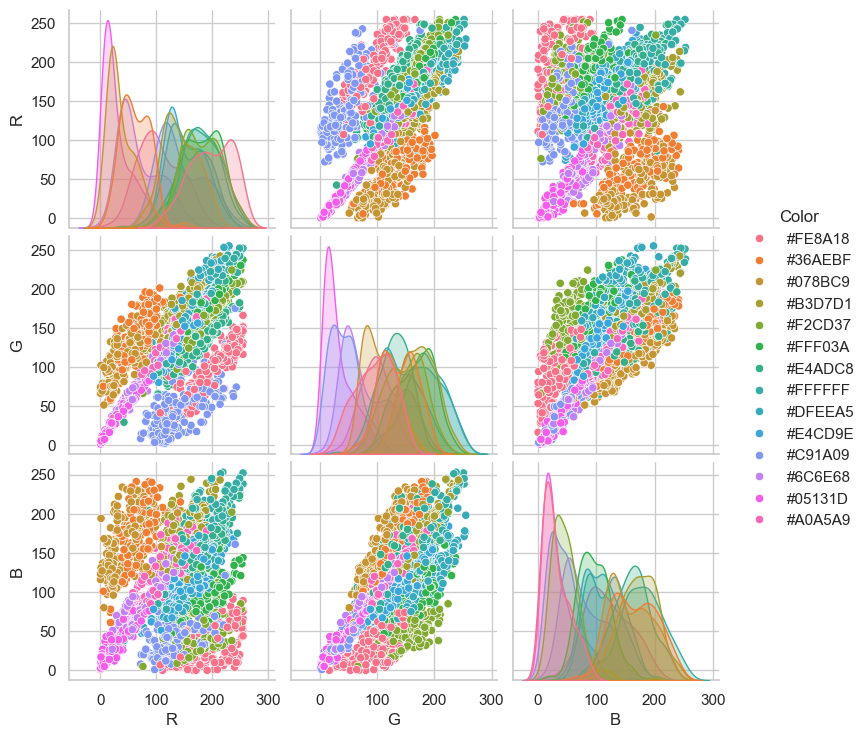

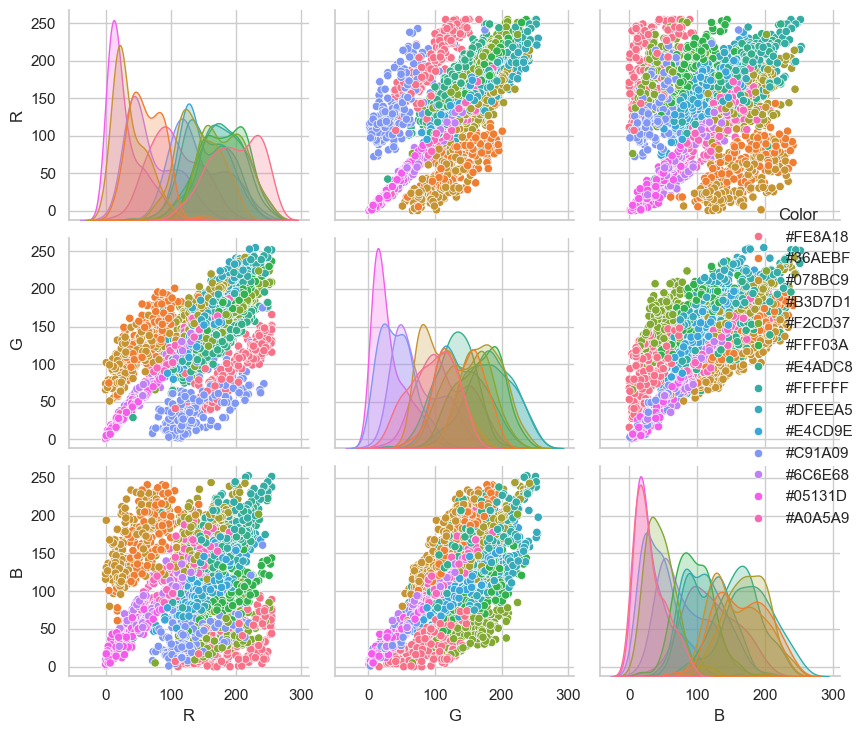

In [114]:
import matplotlib.pyplot as plt
sns.set(style = 'whitegrid', context = 'notebook')
print("Trwa proces przygotowywania danych do wizualicji")
sns.pairplot(df_data, vars = df_data.columns[2:5], hue = "Color", height = 2.5)
plt.tight_layout()
plt.show()

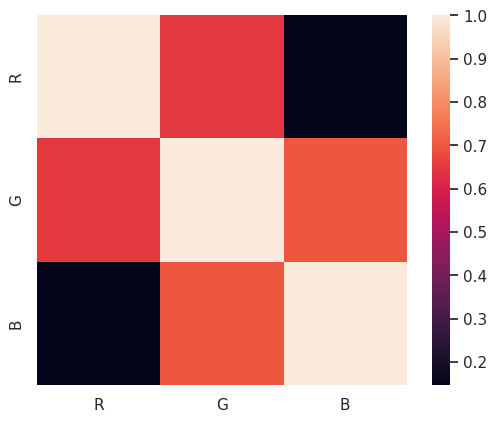

<Figure size 1000x800 with 0 Axes>

In [117]:
from sklearn.preprocessing import StandardScaler 
# Z-normalizacja danych, skalowanie cech
sc = StandardScaler()
Z = sc.fit_transform(X)
# Estymacja macierzy korelacji
R = np.dot(Z.T, Z) / df_data.shape[0]
sns.set(font_scale=1.0)
ticklabels = [s for s in X.columns]
hm = sns.heatmap( R, cbar = True, square = True, yticklabels = ticklabels, xticklabels =
ticklabels )
sns.reset_orig()
plt.figure(figsize=(10, 8))
plt.tight_layout()
plt.show()
sns.reset_orig()

PCA


In [118]:
eigen_vals, eigen_vecs = np.linalg.eigh(R)
print('\nWartosci wlasne: \n%s' % eigen_vals)
tot = sum(np.abs(eigen_vals))
var_exp = [(i / tot) for i in sorted(np.abs(eigen_vals), reverse=True)]
cum_var_exp = np.cumsum(var_exp)


Wartosci wlasne: 
[0.11970288 0.85263465 2.02766247]


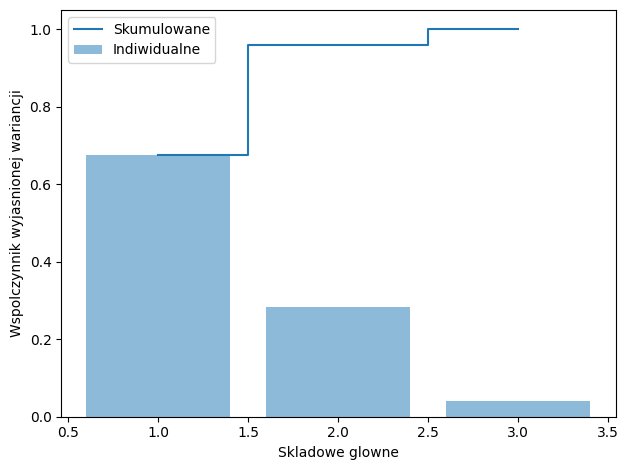

In [119]:

plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha=0.5, align='center',
label='Indiwidualne')
plt.step(range(1, eigen_vals.size + 1), cum_var_exp, where='mid', label='Skumulowane')
plt.ylabel('Wspolczynnik wyjasnionej wariancji')
plt.xlabel('Skladowe glowne')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [120]:
# Utworz liste tupli (wartosc wlasna, wektor wlasny)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
# Posortuj tuple (wartosc wlasna, wektor wlasny) od najwyzszej do najnizszej wartosci.
eigen_pairs.sort(reverse=True)
W = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Macierz projekcji W:\n', W)


Macierz projekcji W:
 [[-0.50410914 -0.73452358]
 [-0.67920779  0.01230988]
 [-0.53343299  0.6784715 ]]


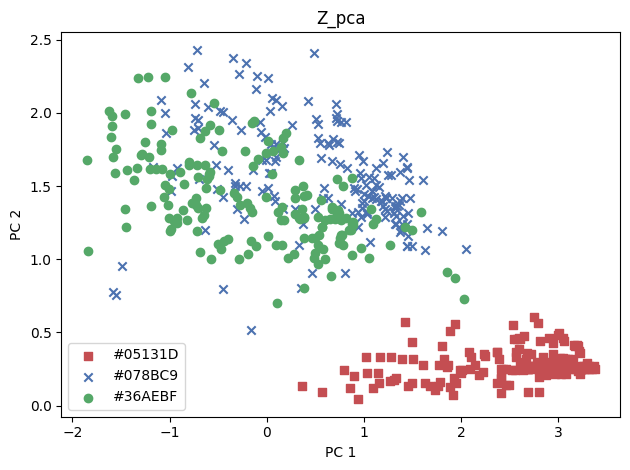

In [127]:
Z_pca = Z.dot(W)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(Y.values), colors, markers):
 plt.scatter(Z_pca[Y.values==l, 0], Z_pca[Y.values==l, 1], c=c, label=l, marker=m)
plt.title('Z_pca')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


DRZEWA DECYZYJNE 


In [3]:
df_data = pd.read_csv('archive/legocolor-basic.csv', delimiter=";")
df_color = pd.read_csv('archive/colors.csv', delimiter=",")
color_dict = dict(zip(df_color["name"], df_color["rgb"]))

df_datacolor=df_data["Color"]

df_data['Color'] = df_data['Color'].replace(color_dict)
df_data['Color'] = '#' + df_data['Color'].astype(str)

X = df_data.drop(labels=['X_axis', 'Y_axis', 'Camera', 'Photo_number', 'Color'], axis = 1)
Y = df_data['Color']

In [4]:
# dzielenie X na zbior treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=0)
print('#Licznosc zbioru treningowego: %d' % X_train.shape[0])
print('#Licznosc zbioru testowego: %d' % X_test.shape[0])
print('Etykiety klasy:', np.unique(Y))


#Licznosc zbioru treningowego: 1993
#Licznosc zbioru testowego: 499
Etykiety klasy: ['#05131D' '#078BC9' '#36AEBF' '#6C6E68' '#A0A5A9' '#B3D7D1' '#C91A09'
 '#DFEEA5' '#E4ADC8' '#E4CD9E' '#F2CD37' '#FE8A18' '#FFF03A' '#FFFFFF']


In [29]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# criterion : funkcja nieczystosci
# max_depth : maksymalna glebokosc drzewa
# random_state : zrodlo generatora liczb losowych
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10,
random_state=0)

tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print('Probki blednie zaklasyfikowane: %d' % (y_test != y_pred).sum())
print('Dokladnosc (drzewo): %.2f' % ((y_test == y_pred).sum() /
y_test.shape[0]))
# bardziej wygodnym sposobem oceny wytrenowanego modelu jest uzycie sklearn.metrics
from sklearn.metrics import accuracy_score
print('Dokladnosc (drzewo, sklearn): %.2f' % accuracy_score(y_test,y_pred))
from sklearn.tree import DecisionTreeClassifier, export_graphviz
export_graphviz( tree,
out_file='tree.dot', feature_names=X.columns.values)

Probki blednie zaklasyfikowane: 117
Dokladnosc (drzewo): 0.77
Dokladnosc (drzewo, sklearn): 0.77


LAS LOSOWY

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy', n_estimators=200,
random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print('Dokladnosc (las): %.2f' % accuracy_score(y_test, y_pred))


Dokladnosc (las): 0.80


 1) R                              0.353639
 2) B                              0.336654
 3) G                              0.309707


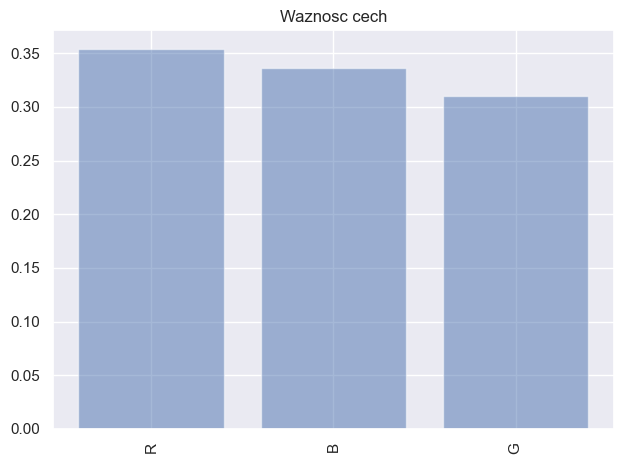

In [45]:
import matplotlib.pyplot as plt
importances = forest.feature_importances_
# uzyskanie indeksow sortowania w porzadku malejacym
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, X.columns.values[indices[f]],
importances[indices[f]]))
plt.figure()
plt.title('Waznosc cech')
plt.bar(range(X_train.shape[1]), importances[indices], align='center', alpha=0.5)
plt.xticks(range(X_train.shape[1]), X.columns.values[indices],
rotation=90)
plt.tight_layout()
plt.show()

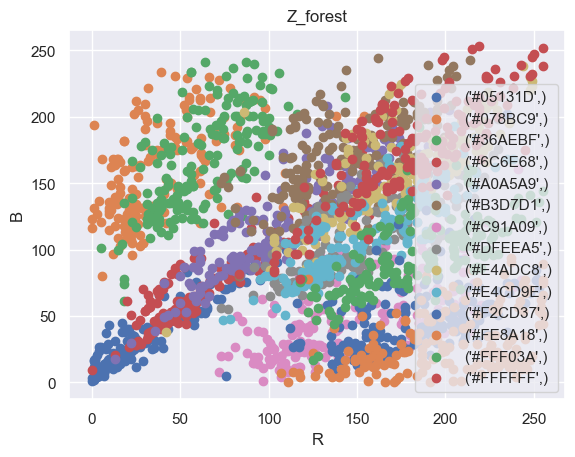

In [55]:
Z_forest = X[['R', 'B', 'G']].values

for l in zip(np.unique(Y.values)):
    plt.scatter(Z_forest[Y.values==l, 0], Z_forest[Y.values==l, 1], label=l)
plt.title('Z_forest')
plt.xlabel('R')
plt.ylabel('B')
plt.legend(loc='lower right')
plt.show()


In [56]:
from sklearn.feature_selection import SelectFromModel
# umiesc predefiniowany RandomForestClassifier "forest" w SelectFromModel
sfm = SelectFromModel(forest, threshold=0.16, prefit=True)
Z_forest_alt = sfm.transform(X)
for f in range(Z_forest_alt.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, X.columns.values[indices[f]],
importances[indices[f]]))

 1) R                              0.353639
 2) B                              0.336654
 3) G                              0.309707


c:\Users\Asus\Desktop\studia\Magisterka\PDiUM\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [63]:
# podzielenie X na zbior szkoleniowy i zbior testowy
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.3, random_state=0)
# trenowanie klasyfikatora RandomForestClassifier jako model
forest = RandomForestClassifier(criterion='entropy', n_estimators=1000,
random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print('Dokladnosc: %.2f' % accuracy_score(y_test, y_pred))
print('Dokladnosc na ceche: %.2f' % (accuracy_score(y_test,y_pred)/X.shape[1]))


Dokladnosc: 0.79
Dokladnosc na ceche: 0.26
